In [12]:
import random
from random import sample
import argparse
import numpy as np
import os
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
# from skimage import morphology
# from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
# import datasets.mvtec as mvtec
import datasets.bowtie as bowtie

# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device:', device)


Device: cuda


In [13]:
def denormalization(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    return x


def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    return z

def plot_fig(test_img, scores, img_scores, save_dir, class_name):
    num = len(scores)
    vmax = scores.max() * 255.
    vmin = scores.min() * 255.
    for i in range(num):
        img = test_img[i]
        img = denormalization(img)
        heat_map = scores[i] * 255
        
        fig_img, ax_img = plt.subplots(1, 3, figsize=(12, 4))
        fig_img.subplots_adjust(right=0.9)
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
            
        ax_img[0].imshow(img)
        ax_img[0].title.set_text('Image')
        
        ax = ax_img[1].imshow(heat_map, cmap='jet', norm=norm)
        ax_img[1].imshow(img, cmap='gray', interpolation='none')
        ax_img[1].imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none')
        ax_img[1].title.set_text('Predicted heat map')
        
        # Add a placeholder for segmentation result and anomaly score
        ax_img[2].imshow(img)
        ax_img[2].title.set_text('Segmentation result')
        ax_img[2].text(5, 20, f'Anomaly Score: {img_scores[i]:.3f}', color='white', backgroundcolor='black')


        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
        cb.ax.tick_params(labelsize=8)
        font = {
            'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
        }
        cb.set_label('Anomaly Score', fontdict=font)

        fig_img.savefig(os.path.join(save_dir, class_name + '_{}'.format(i)), dpi=100)
        plt.close()


In [14]:
arch = "wide_resnet50_2"
data_path = "../anomaly_detection/data/BowTie-New/original"
save_path = "./results/bowtie"

class_name = "116"

In [15]:
# model = resnet18(pretrained=True, progress=True)
# t_d = 448
# d = 100

model = wide_resnet50_2(pretrained=True, progress=True)
t_d = 1792
d = 550

model.to(device)
model.eval()
random.seed(1024)
torch.manual_seed(1024)
if use_cuda:
    torch.cuda.manual_seed_all(1024)

idx = torch.tensor(sample(range(0, t_d), d))

outputs = []

def hook(module, input, output):
    outputs.append(output)

model.layer1[-1].register_forward_hook(hook)
model.layer2[-1].register_forward_hook(hook)
model.layer3[-1].register_forward_hook(hook)

os.makedirs(os.path.join(save_path, 'temp_%s' % arch), exist_ok=True)

In [16]:
total_roc_auc = []

train_dataset = bowtie.BowtieDataset(data_path, class_name=class_name, is_train=True, resize=512, cropsize=400)
train_dataloader = DataLoader(train_dataset, batch_size=32, pin_memory=True)
test_dataset = bowtie.BowtieDataset(data_path, class_name=class_name, is_train=False, resize=512, cropsize=400)
test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

In [17]:
train_dataset.print_dataset_info()

class_name: 116, is_train: True
number of data: 89
number of good: 89, number of anomaly: 0
dataset path: ../anomaly_detection/data/BowTie-New/original
image directory: ../anomaly_detection/data/BowTie-New/original/116/train


In [30]:
train_dataset.x

['../anomaly_detection/data/BowTie-New/original/116/train/good/004.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/005.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/006.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/008.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/009.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/012.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/013.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/014.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/017.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/020.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/022.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/023.jpg',
 '../anomaly_detection/data/BowTie-New/original/116/train/good/024.jpg',
 '../anomaly_detection/data/BowTie-New/original/116

In [18]:
train_feature_filepath = os.path.join(save_path, 'temp_%s' % arch, 'train_%s.pkl' % class_name)
if not os.path.exists(train_feature_filepath):
    for (x, _, _) in tqdm(train_dataloader, '| feature extraction | train | %s |' % class_name):
        with torch.no_grad():
            _ = model(x.to(device))
        for k, v in zip(train_outputs.keys(), outputs):
            train_outputs[k].append(v.cpu().detach())
        outputs = []
    for k, v in train_outputs.items():
        train_outputs[k] = torch.cat(v, 0)

    embedding_vectors = train_outputs['layer1']
    for layer_name in ['layer2', 'layer3']:
        embedding_vectors = embedding_concat(embedding_vectors, train_outputs[layer_name])

    embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
    B, C, H, W = embedding_vectors.size()
    embedding_vectors = embedding_vectors.view(B, C, H * W)
    mean = torch.mean(embedding_vectors, dim=0).numpy()
    cov = torch.zeros(C, C, H * W).numpy()
    I = np.identity(C)
    for i in range(H * W):
        cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
    train_outputs = [mean, cov]
    with open(train_feature_filepath, 'wb') as f:
        pickle.dump(train_outputs, f)
else:
    print('load train set feature from: %s' % train_feature_filepath)
    with open(train_feature_filepath, 'rb') as f:
        train_outputs = pickle.load(f)


| feature extraction | train | 116 |: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


In [19]:
gt_list = []
test_imgs = []

for (x, y, _) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
    test_imgs.extend(x.cpu().detach().numpy())
    gt_list.extend(y.cpu().detach().numpy())
    with torch.no_grad():
        _ = model(x.to(device))
    for k, v in zip(test_outputs.keys(), outputs):
        test_outputs[k].append(v.cpu().detach())
    outputs = []

| feature extraction | test | 116 |: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


In [20]:
for k, v in test_outputs.items():
    test_outputs[k] = torch.cat(v, 0)

In [21]:
embedding_vectors = test_outputs['layer1']
for layer_name in ['layer2', 'layer3']:
    embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])

In [22]:
embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
B, C, H, W = embedding_vectors.size()
embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
dist_list = []
for i in range(H * W):
    mean = train_outputs[0][:, i]
    conv_inv = np.linalg.inv(train_outputs[1][:, :, i])
    dist = [mahalanobis(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
    dist_list.append(dist)

In [23]:
dist_list = np.array(dist_list).transpose(1, 0).reshape(B, H, W)
dist_list = torch.tensor(dist_list)
score_map = F.interpolate(dist_list.unsqueeze(1), size=x.size(2), mode='bilinear',
                            align_corners=False).squeeze().numpy()

In [24]:
for i in range(score_map.shape[0]):
    score_map[i] = gaussian_filter(score_map[i], sigma=4)

In [25]:
max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)

In [26]:
img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
gt_list = np.asarray(gt_list)
fpr, tpr, _ = roc_curve(gt_list, img_scores)
img_roc_auc = roc_auc_score(gt_list, img_scores)
total_roc_auc.append(img_roc_auc)

/home/mikeszklarz/anaconda3/envs/padim/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1192: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/mikeszklarz/anaconda3/envs/padim/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


image ROCAUC: nan


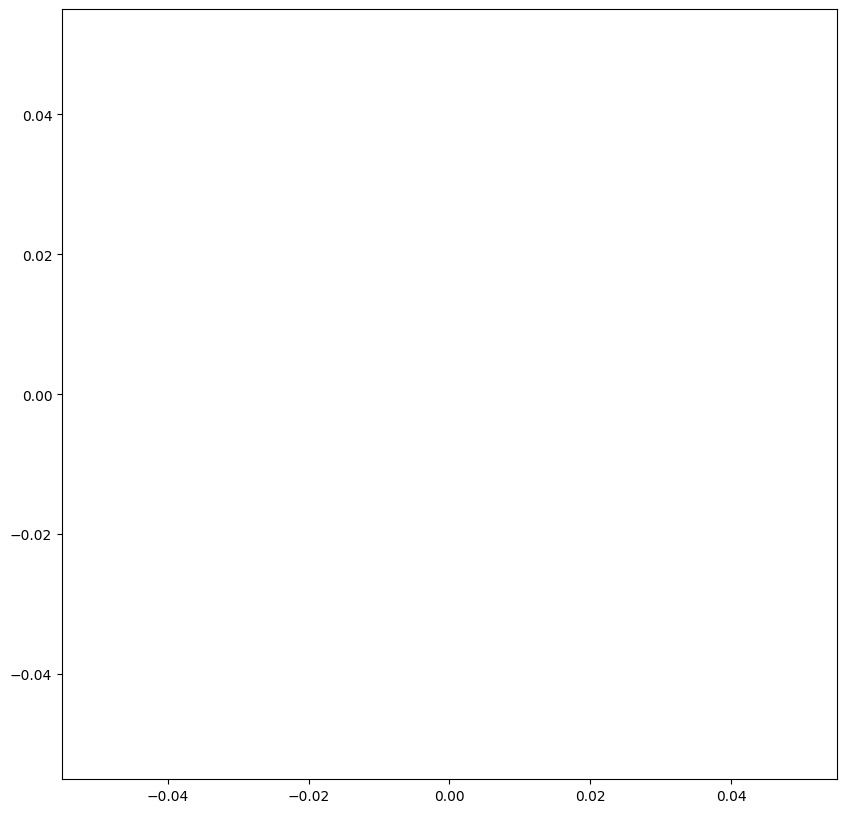

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig_img_rocauc = ax

print('image ROCAUC: %.3f' % (img_roc_auc))
fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC: %.3f' % (class_name, img_roc_auc))

save_dir = save_path + '/' + f'pictures_{arch}'
os.makedirs(save_dir, exist_ok=True)
plot_fig(test_imgs, scores, img_scores, save_dir, class_name)